# Deploying ML Models using MLFlow and Sklearn Pipeline

This notebook is demostrated how to use MLflow and Sklearn to deploy ML models into production. 
MLFlow and Sklearn are very virsetile frameworks and there are multiple ways to deploy ML models with them. 
In this notebook I choose to demotrate a pragmatic 


In [18]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from numpy import savetxt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import os

import mlflow
import mlflow.sklearn

In [6]:
""" Use the house prices dataset for this studynote """

source_dataset = pd.read_csv("../data/House_Price.csv", header=0)

In [26]:
def minimize_dataset(df):
    """ 
    Return a minimized version of the data, 
    to make easy to expirement with feature transformation 
    """

    new_df = pd.DataFrame()

    new_df['price'] = df.price

    # Add new number of hotel rooms to the new df
    new_df['n_hot_rooms'] = df.n_hot_rooms
    
    # Filling missing value in n_hos_beds
    new_df['n_hos_beds'] = df.n_hos_beds

    # Transform the inversely proportional functoin into a liner function using log
    new_df['crime_rate'] = df.crime_rate

    new_df['room_num'] = df.room_num
    new_df['teachers'] = df.teachers
    new_df['waterbody'] = df.waterbody

    new_df['dist1'] = df.dist1
    new_df['dist2'] = df.dist2
    new_df['dist3'] = df.dist3
    new_df['dist4'] = df.dist4
    
    # Convert categorical variables to dummy variables
    #new_df = pd.get_dummies(new_df, drop_first=True)

    return new_df

In [11]:
source_dataset.head()

,price,crime_rate,resid_area,air_qual,room_num,age,dist1,dist2,dist3,dist4,teachers,poor_prop,airport,n_hos_beds,n_hot_rooms,waterbody,rainfall,bus_ter,parks
0,24.0,0.00632,32.31,0.538,6.575,65.2,4.35,3.81,4.18,4.01,24.7,4.98,YES,5.480,11.1920,River,23,YES,0.049347
1,21.6,0.02731,37.07,0.469,6.421,78.9,4.99,4.70,5.12,5.06,22.2,9.14,NO,7.332,12.1728,Lake,42,YES,0.046146
2,34.7,0.02729,37.07,0.469,7.185,61.1,5.03,4.86,5.01,4.97,22.2,4.03,NO,7.394,101.1200,None,38,YES,0.045764
3,33.4,0.03237,32.18,0.458,6.998,45.8,6.21,5.93,6.16,5.96,21.3,2.94,YES,9.268,11.2672,Lake,45,YES,0.047151
4,36.2,0.06905,32.18,0.458,7.147,54.2,6.16,5.86,6.37,5.86,21.3,5.33,NO,8.824,11.2896,Lake,55,YES,0.039474


In [27]:
df = minimize_dataset(source_dataset)
df.head()

,price,n_hot_rooms,n_hos_beds,crime_rate,room_num,teachers,waterbody,dist1,dist2,dist3,dist4
0,24.0,11.1920,5.480,0.00632,6.575,24.7,River,4.35,3.81,4.18,4.01
1,21.6,12.1728,7.332,0.02731,6.421,22.2,Lake,4.99,4.70,5.12,5.06
2,34.7,101.1200,7.394,0.02729,7.185,22.2,None,5.03,4.86,5.01,4.97
3,33.4,11.2672,9.268,0.03237,6.998,21.3,Lake,6.21,5.93,6.16,5.96
4,36.2,11.2896,8.824,0.06905,7.147,21.3,Lake,6.16,5.86,6.37,5.86


In [28]:
df.describe()

,price,n_hot_rooms,n_hos_beds,crime_rate,room_num,teachers,dist1,dist2,dist3,dist4
count,506.000000,506.000000,498.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.528854,13.041605,7.899767,3.613524,6.284634,21.544466,3.971996,3.628775,3.960672,3.618972
std,9.182176,5.238957,1.476683,8.601545,0.702617,2.164946,2.108532,2.108580,2.119797,2.099203
min,5.000000,10.057600,5.268000,0.006320,3.561000,18.000000,1.130000,0.920000,1.150000,0.730000
25%,17.025000,11.189800,6.634500,0.082045,5.885500,19.800000,2.270000,1.940000,2.232500,1.940000
50%,21.200000,12.720000,7.999000,0.256510,6.208500,20.950000,3.385000,3.010000,3.375000,3.070000
75%,25.000000,14.170800,9.088000,3.677083,6.623500,22.600000,5.367500,4.992500,5.407500,4.985000
max,50.000000,101.120000,10.876000,88.976200,8.780000,27.400000,12.320000,11.930000,12.320000,11.940000


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        506 non-null    float64
 1   n_hot_rooms  506 non-null    float64
 2   n_hos_beds   498 non-null    float64
 3   crime_rate   506 non-null    float64
 4   room_num     506 non-null    float64
 5   teachers     506 non-null    float64
 6   waterbody    506 non-null    object 
 7   dist1        506 non-null    float64
 8   dist2        506 non-null    float64
 9   dist3        506 non-null    float64
 10  dist4        506 non-null    float64
dtypes: float64(10), object(1)
memory usage: 43.6+ KB


In [30]:
# Prep the data for training and prediction
if 'price' in df: 
    y = df.pop('price')


In [31]:
def get_training_testing_data():
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [32]:
class ColumnAvgTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self,columns, new_column_name):
        self.columns = columns
        self.new_column_name = new_column_name
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X[self.new_column_name] = X[self.columns].mean(axis=1)
        X = X.drop(self.columns, axis=1)
        return X
    

In [33]:
## Feature preprocessing

numeric_features = ['n_hot_rooms','n_hos_beds','room_num','teachers']
numeric_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='mean')),
     ('scaler', StandardScaler())])

categorical_features = [ 'waterbody']
categorical_transformer = Pipeline(steps=[ 
     ('imputer', SimpleImputer(strategy='constant',fill_value=0)),
     ('ordinal_encoder', preprocessing.OrdinalEncoder())])

log_features = ['crime_rate']
log_transformer = Pipeline(steps=[
     #('imputer', SimpleImputer(strategy='median')),
     ('log_tranformer', FunctionTransformer(np.log1p, validate=True))
])

"""
The remainder passthrough let columns that are not specified 
in the ColumnTransfer passthrough 
""" 
preprocessor = ColumnTransformer(
     transformers=[
          ('num', numeric_transformer, numeric_features),
          ('cat', categorical_transformer, categorical_features),
          ('log', log_transformer, log_features)
          ], 
          remainder='passthrough'
     )




In [34]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [35]:
X_train, X_test, y_train, y_test = get_training_testing_data()

In [36]:
params = {'max_depth':13, 'n_estimators':1000, 'learning_rate':1.0, 'subsample':0.7, 'colsample_bytree':0.8}


model = Pipeline(steps=[
    ('avg_dist_transformer', ColumnAvgTransformer(['dist1', 'dist2', 'dist3', 'dist4'], 'avg_dist')),
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBRegressor(**params))
    ], verbose=True)

In [37]:
model.fit(X_train, y_train)

[Pipeline]  (step 1 of 3) Processing avg_dist_transformer, total=   0.0s
[Pipeline] ...... (step 2 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.2s


Pipeline(steps=[('avg_dist_transformer',
                 ColumnAvgTransformer(columns=['dist1', 'dist2', 'dist3',
                                               'dist4'],
                                      new_column_name='avg_dist')),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['n_hot_rooms', 'n_hos_beds',
                                                   'room_num', 'teachers']),
                                                 ('cat',
                                                  Pipeli...
        

In [38]:
predictions = model.predict(X_test)
print(mean_squared_error(y_pred = predictions, y_true= y_test))
print(mean_absolute_error(y_pred = predictions, y_true= y_test))

31.121527778609032
3.4603142164501484


In [43]:
EXPERIMENT_NAME = "house_prices_sklearn_pipe_xgb"
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment(EXPERIMENT_NAME)
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
print("experiment_id:", experiment.experiment_id)


2023/03/06 09:00:50 INFO mlflow.tracking.fluent: Experiment with name '5_experiment_house_prices_xgb_ipynb' does not exist. Creating a new experiment.


experiment_id: 9


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.5s


Registered model 'house_prices_xgb_model_1' already exists. Creating a new version of this model...
2023/03/06 09:00:55 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: house_prices_xgb_model_1, version 4
Created version '4' of model 'house_prices_xgb_model_1'.


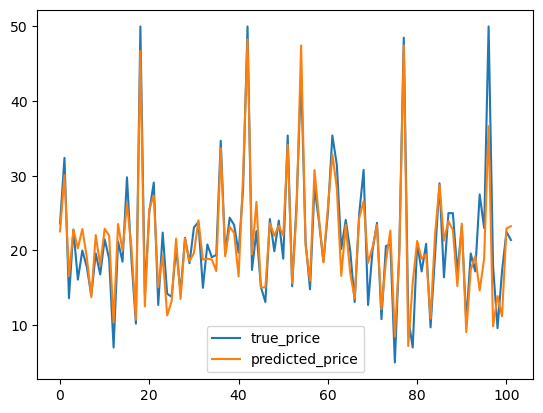

In [44]:
with mlflow.start_run() as model_tracking_run:

    ## Get Training Data
    X_train, X_test, y_train, y_test = get_training_testing_data()
    
    ## Construct Model 
    params = {'max_depth':12, 'n_estimators':1000, 'learning_rate':0.1, 'subsample':0.8, 'colsample_bytree':0.8}

    ## Log model params in MLFlow
    mlflow.log_params(params)

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBRegressor(**params))
        ], verbose=True)
    
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    artifact_path = f"artifacts_stage/run_{model_tracking_run.info.run_id}"

    ## Log model in MLFlow
    mlflow.sklearn.log_model(sk_model = model, 
        artifact_path="skl_pipe_xgb_house_prices",
        registered_model_name = "house_prices_xgb_model_1")

    rmse, mae, r2 = eval_metrics(y_test, predictions)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    artifact_path = f"artifacts_stage/run_{model_tracking_run.info.run_id}"
    os.mkdir(artifact_path)


    ## Save and log predicted values
    prediction_file = f"{artifact_path}/prediction.csv"
    savetxt(prediction_file, predictions)
    mlflow.log_artifact(prediction_file)

    ## Create a plot that shows predicted vs true prices
    compare = pd.DataFrame({0:y_test.values, 1:predictions })
    compare.columns=['true_price', 'predicted_price']
    fig = compare.plot(use_index=True).get_figure()
    fig_file = f"{artifact_path}/true_vs_predicted.png"
    fig.savefig(fig_file)
    mlflow.log_artifact(fig_file)




In [60]:
logged_model = 'runs:/c2796c5207b5410cb0a68ba4ed5a6b33/skl_pipe_xgb_house_prices'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [70]:
dir(loaded_model.metadata)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_metadata',
 '_saved_input_example_info',
 '_signature',
 'add_flavor',
 'artifact_path',
 'flavors',
 'from_dict',
 'get_input_schema',
 'get_model_info',
 'get_output_schema',
 'load',
 'load_input_example',
 'log',
 'metadata',
 'mlflow_version',
 'model_uuid',
 'run_id',
 'save',
 'saved_input_example_info',
 'signature',
 'to_dict',
 'to_json',
 'to_yaml',
 'utc_time_created']

In [77]:
import mlflow.pyfunc

model_name = "house_prices_xgb_model_1"
stage = 'Staging'
model_uri=f"models:/{model_name}/{stage}"


model = mlflow.pyfunc.load_model(model_uri)
print(model_uri)
model.predict(X_test)

models:/house_prices_xgb_model_1/Staging


array([22.981283, 30.136358, 17.367483, 22.758842, 19.641615, 22.305285,
       19.027924, 14.624709, 20.839834, 18.13437 , 21.552773, 20.82225 ,
       11.442851, 23.997944, 20.47921 , 31.649529, 19.965816,  9.975837,
       44.33097 , 12.684249, 24.990417, 26.749693, 16.397635, 21.941044,
       11.926445, 13.364957, 22.191189, 12.907046, 21.53167 , 17.329403,
       20.316465, 23.641134, 21.432373, 17.420328, 18.567915, 19.495022,
       34.89803 , 19.695057, 22.674723, 22.045515, 17.237652, 28.93987 ,
       49.165432, 18.854998, 25.261135, 18.260849, 15.550772, 23.528383,
       19.560045, 22.660078, 20.357428, 32.772358, 17.198944, 26.671457,
       48.977634, 20.827562, 20.47024 , 27.866272, 23.022234, 19.787113,
       23.9338  , 35.53965 , 26.959204, 16.159908, 22.49341 , 18.218952,
       15.509234, 23.838472, 27.373453, 17.61049 , 21.294327, 28.604715,
       14.582991, 17.010658, 23.160679,  8.789547, 19.671293, 47.17371 ,
        7.768948, 16.476809, 22.799988, 14.243485, 

In [100]:

import requests
from json import JSONEncoder

host = '0.0.0.0'
port = '8001'

url = f'http://{host}:{port}/invocations'

headers = {
    'Content-Type': 'application/json',
}

# test_data is a Pandas dataframe with data for testing the ML model
http_data = X_test.to_dict(orient='split')

x = JSONEncoder().encode({"dataframe_split": http_data})

r = requests.post(url=url, headers=headers, data=x)

print(f'Predictions: {r.text}')

Predictions: {"predictions": [22.98128318786621, 30.1363582611084, 17.367483139038086, 22.75884246826172, 19.64161491394043, 22.30528450012207, 19.027923583984375, 14.624709129333496, 20.839834213256836, 18.134370803833008, 21.552772521972656, 20.822250366210938, 11.442851066589355, 23.997943878173828, 20.479209899902344, 31.64952850341797, 19.965816497802734, 9.975836753845215, 44.330970764160156, 12.684248924255371, 24.99041748046875, 26.749692916870117, 16.397634506225586, 21.941043853759766, 11.926445007324219, 13.364956855773926, 22.19118881225586, 12.9070463180542, 21.53166961669922, 17.329402923583984, 20.316465377807617, 23.64113426208496, 21.432373046875, 17.42032814025879, 18.567914962768555, 19.49502182006836, 34.89802932739258, 19.695056915283203, 22.67472267150879, 22.045515060424805, 17.237651824951172, 28.939870834350586, 49.16543197631836, 18.854997634887695, 25.26113510131836, 18.260848999023438, 15.550771713256836, 23.528383255004883, 19.56004524230957, 22.66007804870

In [74]:
from pprint import pprint
from mlflow import MlflowClient

client = MlflowClient()
for rm in client.search_registered_models():
    pprint(dict(rm), indent=4)

{   'creation_timestamp': 1677505289106,
    'description': '',
    'last_updated_timestamp': 1677506861344,
    'latest_versions': [   <ModelVersion: creation_timestamp=1677505289239, current_stage='Staging', description='', last_updated_timestamp=1677506861344, name='HousePrices_Model_A', run_id='123224b04e3748a6a79f4ae615902225', run_link='', source='mlflow-artifacts:/2/123224b04e3748a6a79f4ae615902225/artifacts/preprocess_and_xgb', status='READY', status_message='', tags={}, user_id='', version='1'>,
                           <ModelVersion: creation_timestamp=1677506774841, current_stage='None', description='', last_updated_timestamp=1677506774841, name='HousePrices_Model_A', run_id='2f72025b8d63454b8cdddd034107ca2f', run_link='', source='mlflow-artifacts:/2/2f72025b8d63454b8cdddd034107ca2f/artifacts/preprocess_and_xgb', status='READY', status_message='', tags={}, user_id='', version='2'>],
    'name': 'HousePrices_Model_A',
    'tags': {}}
{   'creation_timestamp': 1677586806039,

In [32]:

mlflow models serve --model-uri runs:/a00a3ca187b943c4bdb644787bd6b277/model

In [40]:
y_pred = pd.Series(data =predictions, name="Predicted_Price")

In [59]:
compare = pd.DataFrame(np.hstack((y_pred[:, None], y_test[:, None])))

/tmp/ipykernel_415888/2907599412.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  compare = pd.DataFrame(np.hstack((y_pred[:, None], y_test[:, None])))


In [68]:
compare = pd.DataFrame({0:y_test.values, 1:predictions })
compare.columns=['true_price', 'predicted_price']

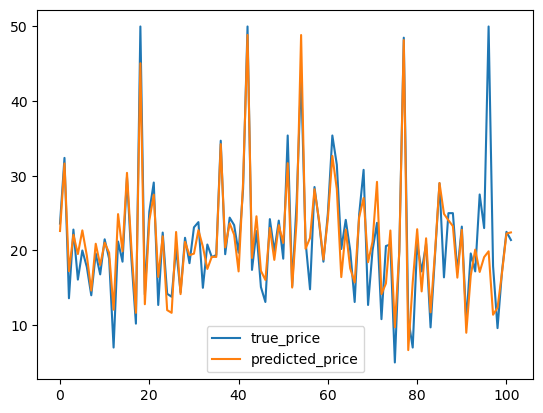

In [76]:
fig = compare.plot(use_index=True).get_figure()
xf = 1234
fig.savefig(f"some_file_{xf}.png")

In [247]:
class Pipeline_Eval:
    def __init__(self, X_dataset, y_dataset):
        self.__pipelines = set()
        self.transformers = []
        self.estimators = []
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(df, y, test_size=0.2, random_state=42)
        return self
    
    
    def constructor(self):
        """Combine the treansfors and estiators list into pipelines"""
        for e in self.estimators:
            steps = self.transformers.copy()
            steps.append(e)
            print(steps)
            pipe = Pipeline(steps)
            print("Pipeline was created")
            print(pipe)
            self.__pipelines.add(pickle.dumps(pipe))



    def eval_pipeline(self, pipe):
        print("Eval Pipeline")
        pipe.fit(self.X_train, self.y_train)
        pred = pipe.predict(self.X_test)
        mae = mean_absolute_error(pred, self.y_test)
        print("PIpeline:")
        print(pipe)
        print(f"Mean Absolute Error {mae:.4f}")


    def add_pipeline(self, pipe):
        self.__pipelines.add(pickle.dumps(pipe))


    def fit_predict(self):
        for pipe in self.__pipelines:
            self.eval_pipeline(pickle.loads(pipe))

    

In [248]:
peval = Pipeline_Eval(df, y)

In [249]:
peval.transformers.append(('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='mean')))
peval.estimators.append(('linear_reg', LinearRegression()))
peval.constructor()
peval.fit_predict()

[('simple_imputer', SimpleImputer()), ('linear_reg', LinearRegression())]
Pipeline was created
Pipeline(steps=[('simple_imputer', SimpleImputer()),
                ('linear_reg', LinearRegression())])
Eval Pipeline
PIpeline:
Pipeline(steps=[('simple_imputer', SimpleImputer()),
                ('linear_reg', LinearRegression())])
Mean Absolute Error 3.8229


In [250]:
peval.estimators.append(('xgb_reg', xgb.XGBRFRegressor(max_depth=13, learning_rate=1.0)))

peval.constructor()
peval.fit_predict()



[('simple_imputer', SimpleImputer()), ('linear_reg', LinearRegression())]
Pipeline was created
Pipeline(steps=[('simple_imputer', SimpleImputer()),
                ('linear_reg', LinearRegression())])
[('simple_imputer', SimpleImputer()), ('xgb_reg', XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=13, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
      

In [251]:
peval.fit_predict()

Eval Pipeline
PIpeline:
Pipeline(steps=[('simple_imputer', SimpleImputer()),
                ('xgb_reg',
                 XGBRFRegressor(base_score=0.5, booster='gbtree',
                                callbacks=None, colsample_bylevel=1,
                                colsample_bytree=1, early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=0, gpu_id=-1,
                                grow_policy='depthwise', importance_type=None,
                                interaction_constraints='', max_bin=256,
                                max_cat_threshold=64, max_cat_to_onehot=4,
                                max_delta_step=0, max_depth=13, max_leaves=0,
                                min_child_weight=1, missing=nan,
                                monotone_constraints='()', n_estimators=100,
                                n_jobs=0, num_parallel_tree=100,
                    

In [232]:
peval.add_pipeline(Pipeline([
    ('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('lasso_regression', linear_model.Lasso(alpha=0.1))
]))

In [252]:
peval.estimators.append(('lasso_regression', linear_model.Lasso(alpha=0.1)))

In [253]:
peval.transformers.append(('standard_scaler', StandardScaler()))

In [255]:
peval.constructor()

[('simple_imputer', SimpleImputer()), ('standard_scaler', StandardScaler()), ('linear_reg', LinearRegression())]
Pipeline was created
Pipeline(steps=[('simple_imputer', SimpleImputer()),
                ('standard_scaler', StandardScaler()),
                ('linear_reg', LinearRegression())])
[('simple_imputer', SimpleImputer()), ('standard_scaler', StandardScaler()), ('xgb_reg', XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=13, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estima

In [256]:
peval.fit_predict()

Eval Pipeline
PIpeline:
Pipeline(steps=[('simple_imputer', SimpleImputer()),
                ('standard_scaler', StandardScaler()),
                ('lasso_regression', Lasso(alpha=0.1))])
Mean Absolute Error 3.8122
Eval Pipeline
PIpeline:
Pipeline(steps=[('simple_imputer', SimpleImputer()),
                ('standard_scaler', StandardScaler()),
                ('xgb_reg',
                 XGBRFRegressor(base_score=0.5, booster='gbtree',
                                callbacks=None, colsample_bylevel=1,
                                colsample_bytree=1, early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=0, gpu_id=-1,
                                grow_policy='depthwise', importance_type=None,
                                interaction_constraints='', max_bin=256,
                                max_cat_threshold=64, max_cat_to_onehot=4,
                                ma

Standard Scaler
The standard scaler shift the data so that the mean is zero and the std deviation (unit variance) is one. 

## Simple example from https://scikit-learn.org/stable/modules/preprocessing.html



In [7]:
raw_data = np.array([[1., -1., 2.],
                [2.,  0., 0.],
                [0., 1., -1.]])

# Scaler is being fit to data 
scaler = preprocessing.StandardScaler().fit(raw_data)

print(f"Data mean: {scaler.mean_}")
print(f"Data scaler to adjust to zero mean: {scaler.scale_}")

# The scaler is used to transform the data
scaled_data = scaler.transform(raw_data)
print("Scaled data")
scaled_data

Data mean: [1.         0.         0.33333333]
Data scaler to adjust to zero mean: [0.81649658 0.81649658 1.24721913]
Scaled data


array([[ 0.        , -1.22474487,  1.33630621],
       [ 1.22474487,  0.        , -0.26726124],
       [-1.22474487,  1.22474487, -1.06904497]])

In [8]:
# Use StandardScaler to normalized number of hospital beds
nor_hosp_beds = preprocessing.StandardScaler().fit_transform(df[['n_hos_beds']])

type(nor_hosp_beds)


hp.head()

,price,resid_area,room_num,teachers
0,24.0,32.31,6.575,24.7
1,21.6,37.07,6.421,22.2
2,34.7,37.07,7.185,22.2
3,33.4,32.18,6.998,21.3
4,36.2,32.18,7.147,21.3


In [19]:
# hp = house prices
# shp = scale house prices. It's imported to explicitly copy the data frame. 
# Otherwise pandas will use a view of the original data frame 
shp = hp.copy()
shp.loc[:, ('resid_area', 'room_num', 'teachers')] = scaler.fit_transform(
    shp[['resid_area', 'room_num', 'teachers']].to_numpy())

shp.head()

,price,resid_area,room_num,teachers
0,24.0,-1.287909,0.413672,1.459000
1,21.6,-0.593381,0.194274,0.303094
2,34.7,-0.593381,1.282714,0.303094
3,33.4,-1.306878,1.016303,-0.113032
4,36.2,-1.306878,1.228577,-0.113032


## Simple pipeline that use the standard scaler and classification problem 
source: https://scikit-learn.org/stable/modules/preprocessing.html

In [21]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [22]:
X, y = make_classification(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)


0.96

In [181]:
pipe = Pipeline([
    ('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('standard_scaler', StandardScaler()),
    ('linear_reg', LinearRegression())
])
peval.eval_pipeline(pipe)

PIpeline:
Pipeline(steps=[('simple_imputer', SimpleImputer()),
                ('standard_scaler', StandardScaler()),
                ('linear_reg', LinearRegression())])
Mean Absolute Error 3.8229


### Standardize value range, scalling the feature to lie between minimum and a maximum using `MinMaxScaler` and `MaxAbsScaler`

The motivation for standardize to a range is to increase the effectiveness of data with small standard deviations and preserve zero enteries. 

In [24]:
raw_data

array([[ 1., -1.,  2.],
       [ 2.,  0.,  0.],
       [ 0.,  1., -1.]])

In [36]:
min_max_scaler = preprocessing.MinMaxScaler()
raw_data_minmax_scaled = min_max_scaler.fit_transform(raw_data)
raw_data_minmax_scaled

# Why zero have two different value below? 

array([[0.5       , 0.        , 1.        ],
       [1.        , 0.5       , 0.33333333],
       [0.        , 1.        , 0.        ]])

In [35]:
max_abs_scaler = preprocessing.MaxAbsScaler()
raw_data_maxabs_scaled = max_abs_scaler.fit_transform(raw_data)
raw_data_minmax_scaled

array([[0.5       , 0.        , 1.        ],
       [1.        , 0.5       , 0.33333333],
       [0.        , 1.        , 0.        ]])

In [31]:
raw_data.min(axis=0)

array([ 0., -1., -1.])

### Standardize sparse data
Normalize sparse data to a center will destroy the sparseness struture of the data. However, it can be useful to scale sparse inputs if the feature are on different scales. 

If there is a need to scale sparse data, use the MaxAbsScaler or the StandardScaler with_mean = False

In [39]:
#todo learn what is sparse data and play with examples. 

sparse_data = np.array([[1., -1., 0., 0., 1., 0.],
                        [2.,  0., 0., 0., 0., 0.],
                        [0.,  1., 0., 0., 0., 1.],
                        [1.,  0., 0., 0., 0., 1.],
                        [0.,  1., 0., 0., 0., 0.]])


In [44]:
max_abs_scaler = preprocessing.MaxAbsScaler()
snd_scaler = preprocessing.StandardScaler(with_mean=False)

In [45]:
sparse_data_max_abs_scaled = max_abs_scaler.fit_transform(sparse_data)
sparse_data_max_abs_scaled

array([[ 0.5, -1. ,  0. ,  0. ,  1. ,  0. ],
       [ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ,  0. ,  0. ,  1. ],
       [ 0.5,  0. ,  0. ,  0. ,  0. ,  1. ],
       [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ]])

In [46]:
sparse_data_snd_scaled = snd_scaler.fit_transform(sparse_data)
sparse_data_max_abs_scaled

array([[ 0.5, -1. ,  0. ,  0. ,  1. ,  0. ],
       [ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ,  0. ,  0. ,  1. ],
       [ 0.5,  0. ,  0. ,  0. ,  0. ,  1. ],
       [ 0. ,  1. ,  0. ,  0. ,  0. ,  0. ]])

## Using RobustScaler to deal with outlier

Test data will by the number of hospital rooms in the house pricing dataset

In [48]:
df.head()

,price,crime_rate,resid_area,air_qual,room_num,age,dist1,dist2,dist3,dist4,teachers,poor_prop,airport,n_hos_beds,n_hot_rooms,waterbody,rainfall,bus_ter,parks
0,24.0,0.00632,32.31,0.538,6.575,65.2,4.35,3.81,4.18,4.01,24.7,4.98,YES,5.480,11.1920,River,23,YES,0.049347
1,21.6,0.02731,37.07,0.469,6.421,78.9,4.99,4.70,5.12,5.06,22.2,9.14,NO,7.332,12.1728,Lake,42,YES,0.046146
2,34.7,0.02729,37.07,0.469,7.185,61.1,5.03,4.86,5.01,4.97,22.2,4.03,NO,7.394,101.1200,None,38,YES,0.045764
3,33.4,0.03237,32.18,0.458,6.998,45.8,6.21,5.93,6.16,5.96,21.3,2.94,YES,9.268,11.2672,Lake,45,YES,0.047151
4,36.2,0.06905,32.18,0.458,7.147,54.2,6.16,5.86,6.37,5.86,21.3,5.33,NO,8.824,11.2896,Lake,55,YES,0.039474


In [64]:
hp2 = df[['price', 'n_hot_rooms', 'rainfall']].copy()

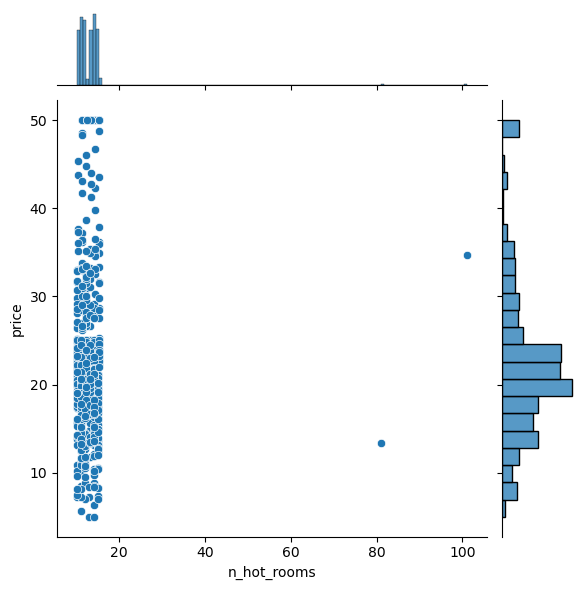

In [56]:
sns.jointplot(x='n_hot_rooms', y='price', data=hp2)

In [59]:
robust_scaler = preprocessing.RobustScaler(unit_variance=True)
hp2.loc[:, ('n_hot_rooms')] = robust_scaler.fit_transform(hp2[['n_hot_rooms']])

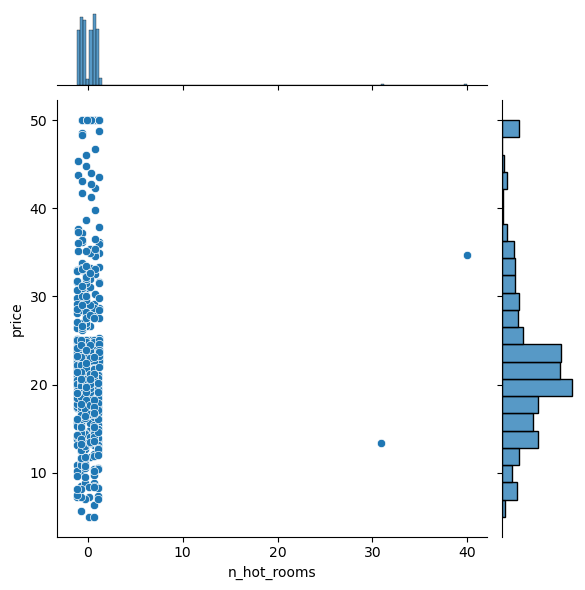

In [60]:
sns.jointplot(x='n_hot_rooms', y='price', data=hp2)

In [78]:
from sklearn.ensemble import IsolationForest
isf_perdiction = IsolationForest(random_state=0).fit_predict(hp2[['n_hot_rooms']])
#clf.predict(hp2[['n_hot_rooms']])
isf_perdiction

array([ 1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,
       -1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1,
        1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1

In [75]:
hp2[['n_hot_rooms']].max()

n_hot_rooms    101.12
dtype: float64

In [81]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=10)
lof_prediction = lof.fit_predict(hp2[['n_hot_rooms']])
lof_prediction

array([ 1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,
        1,  1,  1, -1,  1

In [84]:
hot_rooms = hp2[['n_hot_rooms']].copy()

In [103]:
def is_outlier(X, mean, std, std_from_mean = 2):
    if X > (mean + (std * std_from_mean)) or X < (mean - (std * std_from_mean)):
        return -1
    else:
        return 1

In [106]:
hot_rooms['n_hot_rooms']

0       11.1920
1       12.1728
2      101.1200
3       11.2672
4       11.2896
         ...   
501     12.1792
502     13.1648
503     12.1912
504     15.1760
505     10.1520
Name: n_hot_rooms, Length: 506, dtype: float64

In [107]:
X = hot_rooms['n_hot_rooms'][2]
mean = hot_rooms['n_hot_rooms'].mean()
std = hot_rooms['n_hot_rooms'].std()

print(f" X: {X}, mean: {mean}, std: {std}")

is_outlier(
    X=X, 
    mean=mean, 
    std=std)

 X: 101.12, mean: 13.041604743083003, std: 5.238956632876972


-1

In [116]:
mean = hot_rooms['n_hot_rooms'].mean()
std = hot_rooms['n_hot_rooms'].std()

hot_rooms['is_outlier'] = hot_rooms.apply(lambda x: is_outlier(
    X = x['n_hot_rooms'],
    mean = x.mean(),
    std = x.std()
), axis=1)

In [123]:
hot_rooms['local_outlier'] = lof_prediction.tolist()

In [132]:
hot_rooms['isolation_forest'] = isf_perdiction.tolist()

In [125]:
from sklearn.metrics import accuracy_score
accuracy_score(hot_rooms['is_outlier'], hot_rooms['local_outlier'])

0.8774703557312253

In [134]:
accuracy_score(hot_rooms['is_outlier'], hot_rooms['isolation_forest'])

0.7470355731225297

In [147]:
lof = LocalOutlierFactor(n_neighbors=100, algorithm='brute')
lof_prediction = lof.fit_predict(hp2[['n_hot_rooms']])
accuracy_score(hot_rooms['is_outlier'], lof_prediction.tolist())

1.0

In [148]:
from sklearn.covariance import EllipticEnvelope

In [172]:
cov = EllipticEnvelope(contamination=0.0001, assume_centered=True).fit(hp2[['n_hot_rooms']])
#accuracy_score(hot_rooms['is_outlier'], cov_prediction.tolist())

In [173]:
cov.covariance_

array([[164.91485257]])

In [162]:
hot_rooms['covariance_outlier'] = cov_prediction.tolist()
hot_rooms.head(5)

,n_hot_rooms,is_outlier,local_outlier,isolation_forest,covariance_outlier
0,11.1920,1,1,1,1
1,12.1728,1,1,1,1
2,101.1200,-1,-1,-1,-1
3,11.2672,1,1,1,1
4,11.2896,1,1,-1,1


In [163]:
hot_rooms[hot_rooms.is_outlier != hot_rooms.covariance_outlier]

,n_hot_rooms,is_outlier,local_outlier,isolation_forest,covariance_outlier
423,81.12,-1,-1,-1,1


In [168]:
hot_rooms[hot_rooms.is_outlier == -1] 

,n_hot_rooms,is_outlier,local_outlier,isolation_forest,covariance_outlier
2,101.12,-1,-1,-1,-1
423,81.12,-1,-1,-1,1
